A notebook for generating the final results for a fully cross-validated transfer analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [97]:
import glob
import os
import os.path
import pathlib
import pickle
import re

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch

from ahrens_wbo.data_processing import label_periods
from ahrens_wbo.data_processing import load_and_preprocess_data
from ahrens_wbo.visualization import plot_segmented_signal

from probabilistic_model_synthesis.gaussian_nonlinear_regression import PriorCollection
from probabilistic_model_synthesis.gaussian_nonlinear_regression import VICollection

from janelia_core.stats.regression import r_squared
from janelia_core.utils.file_system import get_immediate_subfolders
from janelia_core.visualization.volume_visualization import signed_max_proj

In [3]:
%matplotlib notebook

## Parameters go here

In [73]:
# A list of of base_folders with the results of different analyses.  A single analysis consists of 
# runing the full cross-validated results with multiple amounts of training data for models fit
# both individually and combined, with a *single* set of parameters.  In this convention, we could 
# run different analyses using different numbers of hypercubes in the prior, for example, and then compare results. 

base_folders = [r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnlr/same_cond_transfer_analysis/v19']

# The names of files holding post-processed results for each type of analysis
results_files = ['pp_test_results.pkl']

# Subjects we want to evaluate performance on
eval_subjs = [8, 10, 11]

subj_clrs = np.asarray([[1.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0], 
                        [0.0, 0.0, 1.0]])

# Training quantities we want to evaluate performance on
tq_strings = ['fold_str_base_14_tgt_1', 
              'fold_str_base_14_tgt_2',
              'fold_str_base_14_tgt_4',
              'fold_str_base_14_tgt_8',
              'fold_str_base_14_tgt_14']
tq_fracs = np.asarray([1.0/14, 
                       2.0/14, 
                       4.0/14,
                       8.0/14,
                       14.0/14.0])

# Location of folder holding the raw dataset to plot example data from 
raw_folder = r'/groups/bishop/bishoplab/projects/ahrens_wbo/data'

# Location to anatomical stack
anat_file = r'/groups/bishop/bishoplab/projects/ahrens_wbo/data/ReferenceBrain.mat'

# Location to example results folder
ex_results_folder= r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnlr/same_cond_transfer_analysis/v19/fold_str_base_14_tgt_14/fold_0/subj_10/comb/'

# Subject we use as an example when plotting data and posteriors
ex_subject = 10

# Folder to save results in 
save_folder = r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnlr/same_cond_transfer_analysis/v19'

## Define helper functions here

In [5]:
def rmse(truth, est):
    return np.sqrt(np.mean((truth - est)**2, axis=0))

In [6]:
def corr(truth, est):
    n_vars = truth.shape[1]
    corr_coefs = np.zeros(n_vars)
    for v_i in range(n_vars):
        corr_coefs[v_i] = np.corrcoef(truth[:, v_i], est[:, v_i], rowvar=False)[0,1]
    return corr_coefs

In [7]:
def get_analysis_results(base_folder, results_file, fit_type: str = 'ip', data_type: str = 'test'):
    training_quantity_folders = get_immediate_subfolders(base_folder)
    tq_rs = dict()
    for tq_folder in training_quantity_folders:
        tq_folder_path = pathlib.Path(base_folder) / tq_folder
        fold_folders = get_immediate_subfolders(tq_folder_path)
        n_folds = len(fold_folders)
        fold_rs = dict()
        for fold_folder in fold_folders:
            cur_fold = int(re.match('.*_(\d*)', fold_folder)[1])
            fold_folder_path = pathlib.Path(tq_folder_path) / fold_folder
            subj_folders = get_immediate_subfolders(fold_folder_path)
            n_subjs = len(subj_folders)
            subj_rs = dict()
            for subj_folder in subj_folders:
                subj_folder_path = pathlib.Path(fold_folder_path) / subj_folder
                type_folders = get_immediate_subfolders(subj_folder_path)
                eval_subj = int(re.match('.*_(\d*)', subj_folder)[1])
                type_rs = dict()
                for type_folder in type_folders:
                    cur_type = type_folder
                    type_folder_path = pathlib.Path(subj_folder_path) / type_folder
                    results_file_path = type_folder_path / results_file
                    with open(results_file_path, 'rb') as f: 
                        rs = pickle.load(f)
                        r_sq = r_squared(rs[fit_type]['preds'][eval_subj][data_type]['y'], 
                                         rs[fit_type]['preds'][eval_subj][data_type]['y_hat'])
                        
                        rmse_vls = rmse(rs[fit_type]['preds'][eval_subj][data_type]['y'], 
                                        rs[fit_type]['preds'][eval_subj][data_type]['y_hat'])
                        
                        corr_vls = corr(rs[fit_type]['preds'][eval_subj][data_type]['y'], 
                                        rs[fit_type]['preds'][eval_subj][data_type]['y_hat'])
                        
                        raw_vls = {'truth': rs[fit_type]['preds'][eval_subj][data_type]['y'], 
                                   'est': rs[fit_type]['preds'][eval_subj][data_type]['y_hat'], 
                                   't': rs[fit_type]['preds'][eval_subj][data_type]['t']}
                        
                        n_smps = len(rs[fit_type]['preds'][eval_subj][data_type]['t'])
                        elbo = rs[fit_type]['elbos'][eval_subj][data_type]['elbo'].item()/n_smps
                        
                        type_rs[cur_type] = {'r_sq': r_sq, 'rmse': rmse_vls, 'corr': corr_vls, 'elbo': elbo, 
                                             'raw': raw_vls}
                subj_rs[eval_subj] = type_rs
            fold_rs[cur_fold] = subj_rs
        tq_rs[tq_folder] = fold_rs
    return tq_rs

In [8]:
def get_subj_rs(rs, subj, fit_type: str = 'ind', metric: str = 'rmse'):
    """ Gets average performance for a single subject, for each for fold, for a single fit type 
        for a single training quantity. """
    n_folds = len(rs)
    folds = np.sort(np.asarray(list(rs.keys())))
    
    fold_rs = np.zeros(n_folds)
    for f_i, f_n in enumerate(folds):
        fold_rs[f_i] = np.mean(rs[f_n][subj][fit_type][metric])
    return fold_rs

In [9]:
def get_avg_fit_type_rs_for_fixed_training_quantity(rs, subjs, fit_type: str = 'ind', metric: str = 'rmse'):
    """ Gets average and standard error of performance across folds for multiple subjects for a single fit type
        and for a single training quantity."""
    n_subjs = len(subjs)
    mn_rs = np.zeros(n_subjs)
    std_er_rs = np.zeros(n_subjs)
    for s_i, subj in enumerate(subjs):
        fold_rs = get_subj_rs(rs, subj=subj, fit_type=fit_type, metric=metric)
        mn_rs[s_i] = np.mean(fold_rs)
        std_er_rs[s_i] = np.std(fold_rs)/np.sqrt(len(fold_rs))
    return [mn_rs, std_er_rs]
        
        

In [10]:
def get_fit_type_rs(rs, train_quantity_keys, subjs, fit_type: str = 'ind', metric: str = 'rmse'):
    n_train_quantity_keys = len(train_quantity_keys)
    n_subjs = len(subjs)
    mn_rs = np.zeros([n_train_quantity_keys, n_subjs])
    std_er_rs = np.zeros([n_train_quantity_keys, n_subjs])
    for tq_i, tq_key in enumerate(train_quantity_keys):
        mn_rs[tq_i, :],  std_er_rs[tq_i, :] = get_avg_fit_type_rs_for_fixed_training_quantity(rs[tq_key], 
                                                                                              subjs, fit_type, 
                                                                                              metric)
    return mn_rs, std_er_rs

## Get results

In [11]:
c_rs = get_analysis_results(base_folders[0], results_files[0])

In [12]:
comb_rmse_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='comb', metric='rmse')
ind_rmse_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='ind', metric='rmse')

comb_corr_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='comb', metric='corr')
ind_corr_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='ind', metric='corr')

comb_r_sq_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='comb', metric='r_sq')
ind_r_sq_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='ind', metric='r_sq')

comb_elbo = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='comb', metric='elbo')
ind_elbo = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='ind', metric='elbo')

## Plot results

In [13]:
figsize = [2, 2]

plot_results = [(comb_rmse_rs, ind_rmse_rs), 
                (comb_corr_rs, ind_corr_rs), 
                (comb_r_sq_rs, ind_r_sq_rs), 
                (comb_elbo, ind_elbo)
               ]

plot_strs = ['RMSE', 'Corr', 'R Sq.', 'Norm_ELBO']

<IPython.core.display.Javascript object>


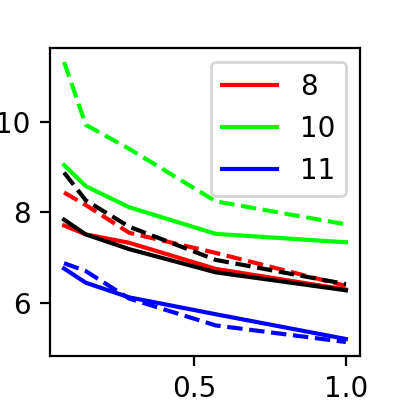

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


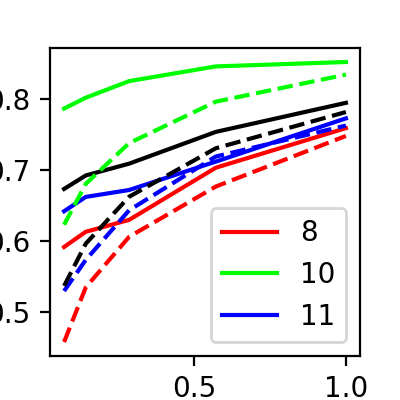

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


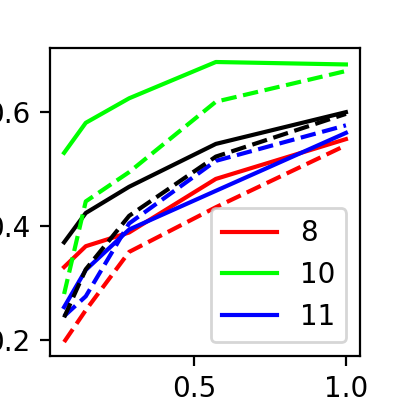

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


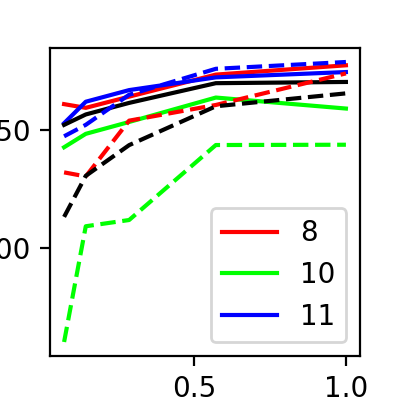

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [14]:
for plot_rs, plot_str in zip(plot_results, plot_strs):
    
    fig, ax = plt.subplots(figsize=figsize)

    for s_i, subj in enumerate(eval_subjs):
        plt.plot(tq_fracs, plot_rs[0][0][:, s_i], '-', color=subj_clrs[s_i])
    plt.legend(eval_subjs)
    
    comb_mn = np.mean(plot_rs[0][0], axis=1)
    plt.plot(tq_fracs, comb_mn, 'k-')
    
                                   
    for s_i, subj in enumerate(eval_subjs):
        plt.plot(tq_fracs, plot_rs[1][0][:, s_i], '--', color=subj_clrs[s_i])  
    
    ind_mn = np.mean(plot_rs[1][0], axis=1)
    plt.plot(tq_fracs, ind_mn, 'k--')
                                   
    plt.xlabel('Training Percentage')
    plt.ylabel(plot_str)
    
    save_name = plot_str + '.eps'
    save_path = pathlib.Path(save_folder) / save_name
    fig.savefig(save_path, format='eps')
                                
                                
    

## Look at example predictions

In [74]:
ex_comb_preds = c_rs['fold_str_base_14_tgt_1'][1][ex_subject]['comb']['raw']
ex_ind_preds = c_rs['fold_str_base_14_tgt_1'][1][ex_subject]['ind']['raw']

<IPython.core.display.Javascript object>


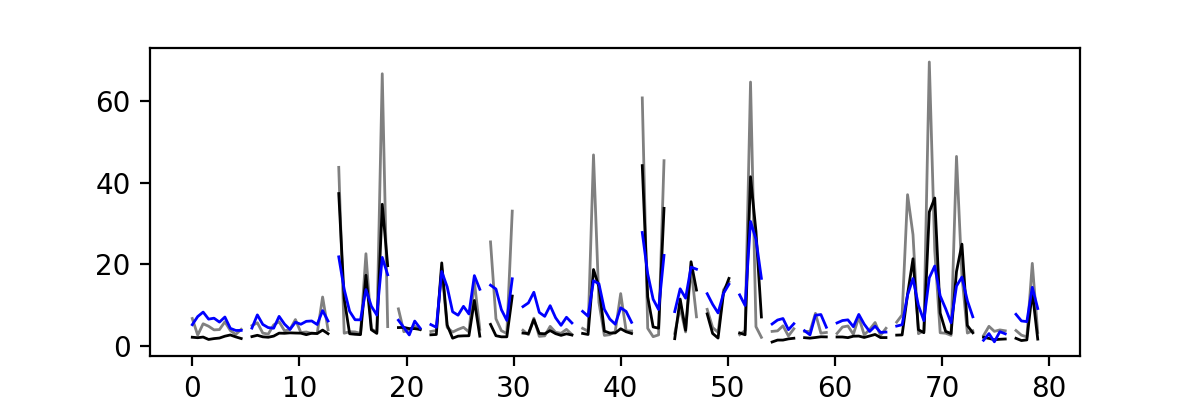

In [75]:
fig, ax = plt.subplots(figsize=[6,figsize[1]])

plot_segmented_signal(tm_pts=ex_comb_preds['t'], sig=ex_comb_preds['truth'][:,0], ax=ax, color='gray', 
                      remove_tm_btw_chunks=True)
plot_segmented_signal(tm_pts=ex_comb_preds['t'], sig=ex_comb_preds['est'][:,0], ax=ax, color='k',
                      remove_tm_btw_chunks=True)

plot_segmented_signal(tm_pts=ex_ind_preds['t'], sig=ex_ind_preds['est'][:,0], ax=ax, color='b',
                      remove_tm_btw_chunks=True)

save_name = 'ex_sigs' + '.eps'
save_path = pathlib.Path(save_folder) / save_name
fig.savefig(save_path, format='eps')

## Plot some raw data

#### Load raw results - we don't use these for the moment, other than allowing us to know what the preprocessing parameters are

In [53]:
ex_rs = torch.load(pathlib.Path(ex_results_folder) / 'test_results.pt')

with open(pathlib.Path(ex_results_folder) / 'pp_test_results.pkl', 'rb') as f:
    ex_pp_rs = pickle.load(f)

In [40]:
subject_data, subject_neuron_locs = load_and_preprocess_data(data_folder=raw_folder,
                                                                 subjects=[ex_subject],
                                                                 normalize_beh_vars=ex_rs['ps']['normalize_beh_vars'],
                                                                 neural_gain=ex_rs['ps']['neural_gain'],
                                                                 beh_gain=ex_rs['ps']['beh_gain'],
                                                                 z_ratio=ex_rs['ps']['z_ratio'])

subject_data = subject_data[ex_subject]
subject_neuron_locs = subject_neuron_locs[ex_subject]

Done loading data for subject subject_10.


In [18]:
ts = subject_data.ts_data['stim']['ts']
stim_vls = subject_data.ts_data['stim']['vls'][:]
dff = subject_data.ts_data['dff']['vls'][:]
beh = subject_data.ts_data['behavior']['vls'][:]

In [19]:
periods = label_periods(stim_vls)
ex_slice = periods['phototaxis'][0]['slice']

#### Plot electrode signal

<IPython.core.display.Javascript object>


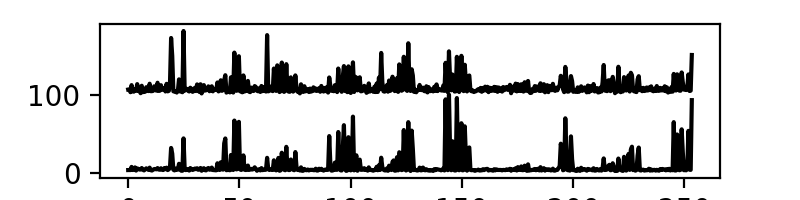

In [20]:
fig, ax = plt.subplots(figsize=[4,1])
ax.plot(ts[ex_slice], beh[ex_slice,0], 'k-')
ax.plot(ts[ex_slice], beh[ex_slice,1]+100, 'k-')

save_name = 'electrode_sigs' + '.eps'
save_path = pathlib.Path(save_folder) / save_name
fig.savefig(save_path, format='eps')

#### Plot neural activity

In [21]:
ex_neuron_inds = [5000, 1100, 15000, 20000, 25000, 30000, 40100, 70500]

<IPython.core.display.Javascript object>


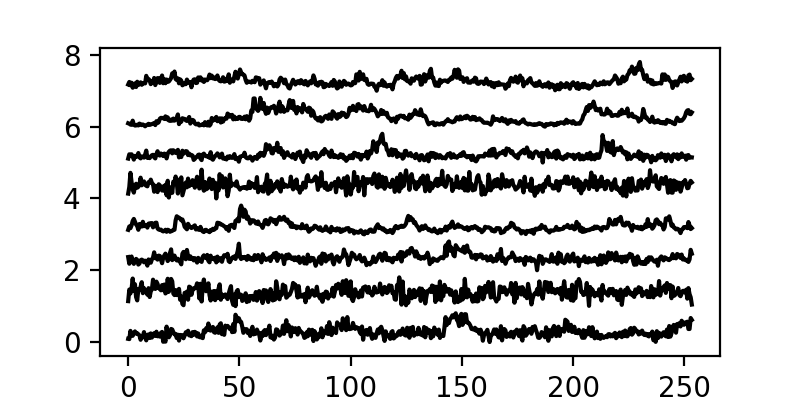

In [22]:
fig, ax = plt.subplots(figsize=[4,2])
for i, neuron_i in enumerate(ex_neuron_inds):
    raw_dff = dff[ex_slice,neuron_i]
    norm_dff = (raw_dff - np.min(raw_dff))/(np.max(raw_dff) - np.min(raw_dff))
    ax.plot(ts[ex_slice], .8*norm_dff + i, 'k-')
    
save_name = 'dff' + '.eps'
save_path = pathlib.Path(save_folder) / save_name
fig.savefig(save_path, format='eps')

## Visualize mean of modes under poseterior and MCPD

#### Load and prepare the image of the raw volume

In [29]:
ref_brain = scipy.io.loadmat(anat_file)
ref_brain = ref_brain['anat_stack_norm']
ref_brain = ref_brain/np.max(ref_brain)

rb_horz = signed_max_proj(ref_brain,2)
rb_sag = signed_max_proj(ref_brain,1)
rb_cor = np.fliplr(signed_max_proj(ref_brain,0))

#### Visualize posterior mode for best model

In [58]:
best_cp_ind = ex_pp_rs['ip']['early_stopping']['best_cp_ind']

In [69]:
# Load check points
cp_dir = pathlib.Path(ex_results_folder) / 'ip_cp'
cp_files = glob.glob(str(cp_dir / 'cp_*.pt'))
n_cps = len(cp_files)
cp_rs = [None] * n_cps
for cp_i, cp_file in enumerate(cp_files):
    cp_rs[cp_i] = torch.load(cp_file)

# Sort check points by epoch
cp_epochs = np.asarray([cp['total_epoch'] for cp in cp_rs])
cp_sort_order = np.argsort(cp_epochs)
cp_epochs = cp_epochs[cp_sort_order]
cp_rs = [cp_rs[i] for i in cp_sort_order]

# Get beck check point
best_cp = cp_rs[best_cp_ind]

In [79]:
ex_ind = np.argwhere(np.asarray(ex_rs['subject_order']) == ex_subject)[0][0]

In [88]:
ex_w_post = best_cp['vi_collections'][4]

In [101]:
best_cp_ind = ex_pp_rs['ip']['early_stopping']['best_cp_ind']
ex_coll = VICollection.from_checkpoint(best_cp['vi_collections'][4])
ex_prior = PriorCollection.from_checkpoint(best_cp['priors'])
ex_w_post = ex_coll.posteriors.w_post

MatrixGaussianProductDistribution(
  (dists): ModuleList(
    (0): CondGaussianDistribution(
      (mn_f): IndSmpConstantRealFcn(
        (f): ConstantRealFcn()
      )
      (std_f): IndSmpConstantBoundedFcn(
        (f): ConstantBoundedFcn()
      )
    )
    (1): CondGaussianDistribution(
      (mn_f): IndSmpConstantRealFcn(
        (f): ConstantRealFcn()
      )
      (std_f): IndSmpConstantBoundedFcn(
        (f): ConstantBoundedFcn()
      )
    )
  )
)

In [89]:
best_cp['vi_collections'][4]

{'mdl': GNLRMdl(
   (m): Sequential(
     (0): DenseLNLNet(
       (dense_lnl_0): DenseLayer(
         (m): Sequential(
           (0): Linear(in_features=2, out_features=5, bias=True)
           (1): ReLU()
         )
       )
       (dense_lnl_1): DenseLayer(
         (m): Sequential(
           (0): Linear(in_features=7, out_features=5, bias=True)
           (1): ReLU()
         )
       )
       (dense_lnl_2): DenseLayer(
         (m): Sequential(
           (0): Linear(in_features=12, out_features=5, bias=True)
           (1): ReLU()
         )
       )
       (dense_lnl_3): DenseLayer(
         (m): Sequential(
           (0): Linear(in_features=17, out_features=5, bias=True)
           (1): ReLU()
         )
       )
       (dense_lnl_4): DenseLayer(
         (m): Sequential(
           (0): Linear(in_features=22, out_features=5, bias=True)
           (1): ReLU()
         )
       )
     )
     (1): Linear(in_features=27, out_features=2, bias=True)
   )
 ),
 'posteriors': {'w_po

{'w_prior': CondMatrixHypercubePrior(
   (dists): ModuleList(
     (0): CondGaussianDistribution(
       (mn_f): SumOfTiledHyperCubeBasisFcns()
       (std_f): Sequential(
         (0): SumOfTiledHyperCubeBasisFcns()
         (1): FixedOffsetExp()
       )
     )
     (1): CondGaussianDistribution(
       (mn_f): SumOfTiledHyperCubeBasisFcns()
       (std_f): Sequential(
         (0): SumOfTiledHyperCubeBasisFcns()
         (1): FixedOffsetExp()
       )
     )
   )
 ),
 's_in_prior': MatrixGaussianProductDistribution(
   (dists): ModuleList(
     (0): CondGaussianDistribution(
       (mn_f): IndSmpConstantRealFcn(
         (f): ConstantRealFcn()
       )
       (std_f): IndSmpConstantBoundedFcn(
         (f): ConstantBoundedFcn()
       )
     )
   )
 ),
 'b_in_prior': MatrixGaussianProductDistribution(
   (dists): ModuleList(
     (0): CondGaussianDistribution(
       (mn_f): IndSmpConstantRealFcn(
         (f): ConstantRealFcn()
       )
       (std_f): IndSmpConstantBoundedFcn(
   